In [33]:
import pandas as pd
import numpy as np
import torch
import os
import sys

sys.path.append('Datasets/')
sys.path.append('models/')

import datasets
import audio_utils
import models

In [146]:
SCAPPER_DF = pd.read_csv('predictions/scapper_scenePredictions_model00.csv')
SCAPPER_AUD_DIR = '../audioData/sythenticSoundscenes/test'
scapper_acoustic_scenes = (list)(SCAPPER_DF['acoustic_scene_label'].unique())

In [76]:
model_path = 'ASC_Model00_00_statedict.pt'
model = models.ASC_Model00(return_second_last=False)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [142]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

def get_logMel_from_fname(audio_fname):
    audio = audio_utils.load_audio_from_file(audio_fname)
    log_mel = audio_utils.get_log_melSpectrogram(audio)
    return log_mel

def zero_signal(log_mel, index):
    log_mel[0][index] = torch.zeros(log_mel[0][index].shape)
    return log_mel

def run_loop(audio_fname, model):
    feat_inva_output_list = []
    input_feats = get_logMel_from_fname(audio_fname)

    n_features = input_feats.shape[1]

    for i in range(n_features):
        input_log_mel = zero_signal(input_feats, i)

        model.eval()
        with torch.inference_mode():
            predictions = model(input_log_mel.unsqueeze(0).to(device))
            predictions = scapper_acoustic_scenes[torch.argmax(torch.sigmoid(predictions.cpu()))]
            print(predictions)
        feat_inva_output_list.append(predictions)
    return feat_inva_output_list


In [109]:
import random
randomly_chosen_files = {}

for i in scapper_acoustic_scenes:
    randomly_chosen_files[i] = []

scapper_true = SCAPPER_DF[SCAPPER_DF['acoustic_scene_label'] == SCAPPER_DF['ASC_predictions_model00']]
    

In [110]:
for i in scapper_acoustic_scenes:
    rand = (list)(scapper_true[scapper_true['acoustic_scene_label'] == i]['audio_fileNames'])
    random.seed(13)
    randomly_chosen_files[i].append(random.sample(rand,10))

In [147]:
predictions_dictionary = {}

for i in scapper_acoustic_scenes:
    for j in randomly_chosen_files[i][0]:
        audio_fname = os.path.join(SCAPPER_AUD_DIR, j)
        predictions_dictionary[audio_fname] = run_loop(audio_fname, model)
        

bus
bus
bus
bus
bus
bus
bus
quietstreet
tube
bus
bus
bus
bus
bus
bus
busystreet
busystreet
bus
bus
bus
park
bus
bus
park
park
bus
bus
bus
park
bus
bus
busystreet
busystreet
bus
bus
park
park
bus
park
park
bus
bus
bus
bus
bus
bus
bus
tubestation
tubestation
bus
bus
bus
bus
bus
bus
busystreet
busystreet
bus
bus
bus
bus
bus
bus
busystreet
busystreet
bus
bus
bus
park
bus
bus
busystreet
busystreet
bus
bus
bus
park
bus
bus
park
office
bus
bus
bus
bus
bus
bus
tube
tube
bus
bus
bus
bus
bus
bus
busystreet
busystreet
bus
bus
bus
bus
bus
bus
busystreet
busystreet
bus
bus
bus
park
bus
bus
busystreet
busystreet
bus
bus
park
park
bus
tube
park
bus
bus
bus
bus
bus
bus
bus
tubestation
tubestation
bus
bus
bus
bus
bus
bus
busystreet
busystreet
bus
bus
bus
bus
bus
bus
busystreet
busystreet
bus
bus
bus
park
bus
bus
busystreet
busystreet
bus
bus
park
park
bus
tube
park
bus
bus
bus
bus
bus
bus
bus
tubestation
busystreet
bus
bus
bus
bus
bus
bus
park
park
bus
bus
bus
bus
bus
bus
busystreet
busystreet
bus
bus


In [153]:
(predictions_dictionary.keys())

dict_keys(['../audioData/sythenticSoundscenes/test/bus2_upshift_3.wav', '../audioData/sythenticSoundscenes/test/bus3_downshift_2.wav', '../audioData/sythenticSoundscenes/test/bus8_upshift_2.wav', '../audioData/sythenticSoundscenes/test/bus2_3.wav', '../audioData/sythenticSoundscenes/test/bus8_downshift_3.wav', '../audioData/sythenticSoundscenes/test/bus2_downshift_5.wav', '../audioData/sythenticSoundscenes/test/bus8_downshift_7.wav', '../audioData/sythenticSoundscenes/test/bus1_upshift_3.wav', '../audioData/sythenticSoundscenes/test/bus2_downshift_3.wav', '../audioData/sythenticSoundscenes/test/bus8_downshift_1.wav', '../audioData/sythenticSoundscenes/test/busystreet3_downshift_7.wav', '../audioData/sythenticSoundscenes/test/busystreet4_downshift_0.wav', '../audioData/sythenticSoundscenes/test/busystreet2_upshift_0.wav', '../audioData/sythenticSoundscenes/test/busystreet3_7.wav', '../audioData/sythenticSoundscenes/test/busystreet2_4.wav', '../audioData/sythenticSoundscenes/test/busystr

In [178]:
test_dict = {}

['bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'quietstreet', 'tube', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'busystreet', 'busystreet', 'bus', 'bus', 'bus', 'park', 'bus', 'bus', 'park', 'park', 'bus', 'bus', 'bus', 'park', 'bus', 'bus', 'busystreet', 'busystreet', 'bus', 'bus', 'park', 'park', 'bus', 'park', 'park']
_
_
_
_
_
_
_
_
_
_
_
_
_
_
['bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'tubestation', 'tubestation', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'busystreet', 'busystreet', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'busystreet', 'busystreet', 'bus', 'bus', 'bus', 'park', 'bus', 'bus', 'busystreet', 'busystreet', 'bus', 'bus', 'bus', 'park', 'bus', 'bus', 'park']
_
_
_
_
_
_
_
_
_
_
_
['office', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'tube', 'tube', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'busystreet', 'busystreet', 'bus', 'bus', 'bus', 'bus', 'bus', 'bus', 'busystreet', 'busystreet', 'bus', 'bus', 'bus', 'park', 'bus', 'bus', 'busystreet', 'busystreet', 'b

In [184]:
x_list = []
for i in randomly_chosen_files.keys():
    #test_dict[i] = {}
    inner_list = []
    for j in randomly_chosen_files[i][0]:
        prediction_list = predictions_dictionary[os.path.join(SCAPPER_AUD_DIR,j)]
        for k in prediction_list:
            if k != i:
                #print(prediction_list.index(k), i)
                inner_list.append(prediction_list.index(k))
    x_list.append(inner_list)
                
        


In [193]:
len(x_list[1])

339

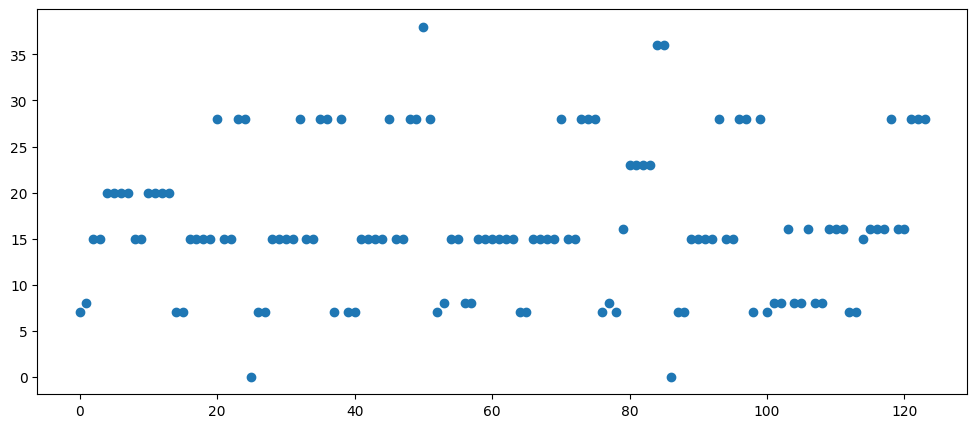

In [207]:
y_axis = [i for i in range(41)]

plt.figure(figsize=(12, 5))
plt.scatter([i for i in range((len(x_list[0])))], x_list[0])


In [215]:
pd.DataFrame(x_list, index=acoustic_scenes)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
bus,7,8,15,15,20,20,20,20,15,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
busystreet,0,1,1,1,1,1,1,7,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
office,1,1,1,1,1,1,7,7,1,1,...,1.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
openairmarket,0,1,1,1,1,1,1,7,7,1,...,0.0,15.0,15.0,0.0,0.0,20.0,20.0,0.0,38.0,20.0
park,0,1,1,1,1,1,1,7,7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quietstreet,0,1,1,1,1,1,1,0,0,1,...,1.0,1.0,36.0,1.0,1.0,36.0,NaN,NaN,NaN,NaN
restaurant,0,1,1,1,1,1,1,7,7,1,...,1.0,15.0,15.0,1.0,1.0,28.0,28.0,1.0,7.0,28.0
supermarket,0,1,1,1,1,1,1,0,0,1,...,0.0,15.0,15.0,0.0,0.0,28.0,28.0,0.0,38.0,28.0
tube,1,1,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tubestation,0,1,1,1,1,1,1,1,1,1,...,1.0,0.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


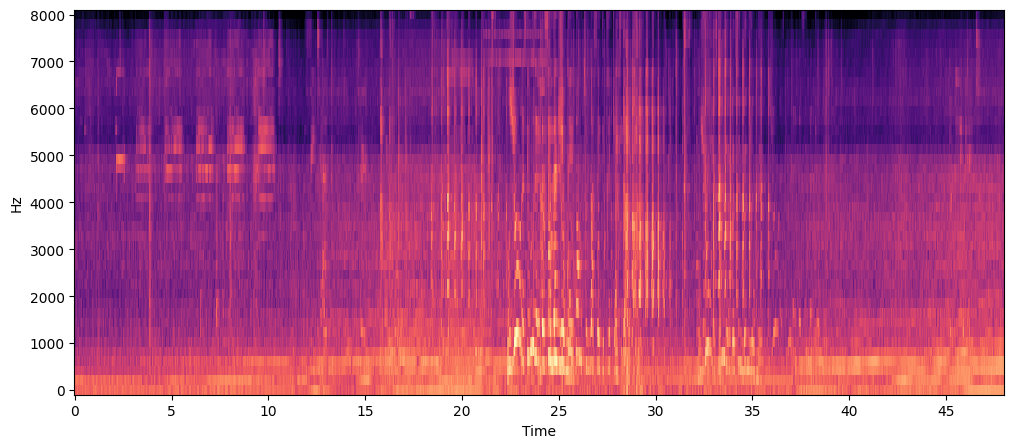

In [71]:
import librosa
import matplotlib.pyplot as plt

sample_file = '../audioData/sythenticSoundscenes/test/bus1_9.wav'
audio = audio_utils.load_audio_from_file(sample_file)
log_mel_feats = audio_utils.get_log_melSpectrogram(audio)

plt.figure(figsize=(12, 5))
librosa.display.specshow(log_mel_feats.squeeze().numpy(), x_axis='time', y_axis='linear', sr=16000)

In [73]:
model.eval()
with torch.inference_mode():
    output = model(log_mel_feats.unsqueeze(0))
    #print(output)

torch.argmax(torch.sigmoid(output))

tensor(2)

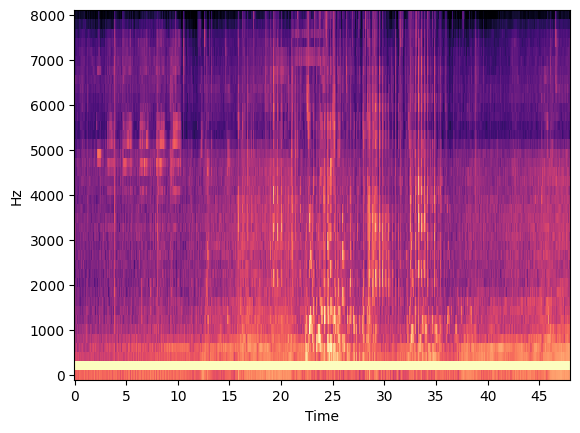

In [74]:
log_mel_feats[0][1] = torch.zeros(log_mel_feats[0][5].shape)

librosa.display.specshow(log_mel_feats.squeeze().numpy(), x_axis='time', y_axis='linear', sr=16000)

In [75]:
model.eval()
with torch.inference_mode():
    output = model(log_mel_feats.unsqueeze(0))

torch.argmax(torch.sigmoid(output))

tensor(0)